# QuickDraw Kaggle competition using FastAi and GoogleCollab
This notebook is based on [Radek Osmulski](https://www.linkedin.com/in/radek-osmulski-6b935794/) entry for the [QuickDraw Kaggle competition](https://www.kaggle.com/c/quickdraw-doodle-recognition).  The original files are available in this [Github repository](https://github.com/radekosmulski/quickdraw).

**Welcome to Google Colab**
https://colab.research.google.com/

Google Colab provides a free Jupyter Notebook environment that includes 4 NVIDIA Tesla K80 GPUs.

**Pricing**
Free

**Steps**

1.   Navigate your browser to https://colab.research.google.com
2.   Sign in to your Google account or create a new one
3.   File->New Python 3 notebook Click the title to rename it to whatever you like.
4.   Runtime->Change runtime type Select GPU from the dropdown menu and click Save
5.   Install PyTorch and FastAI version 1.0.27 as shown below

In [4]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
!pip install fastai==1.0.27
!pip install torchtext==0.2.3

import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
  Using cached https://download.pytorch.org/whl/nightly/cu92/torch_nightly-1.0.0.dev20181206-cp36-cp36m-linux_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x62b3e000 @  0x7fdb2a21a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
1.0.0.dev20181206
True
True


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import fastai
print(fastai.__version__)
from fastai import *
from fastai.vision import *

1.0.27


**Upload utils.py library** 
1.   Press the > symbol below Google Collab icon.
2.   Click on Files
3.   Click on upload and select utils.py



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

import json

from utils import *

In [0]:
NUM_SAMPLES_PER_CLASS = 1_000
NUM_VAL = 50 * 340

1.   Press the > symbol below Google Collab icon
2.   Click on upload
3.   Upload test_simplified.csv
4.   Upload train_simplified.zip



In [0]:
!mkdir data
PATH = Path('data/txt')

In [0]:
PATH.mkdir(exist_ok=True)
(PATH/'train').mkdir(exist_ok=True)
(PATH/'test').mkdir(exist_ok=True)

In [12]:
shutil.move("test_simplified.csv", "data")

'data/test_simplified.csv'

1.   Upload kaggle.json using Google Collab
2.   kaggle.json can be found in your Kaggle.com account profile

In [13]:
PATH2 = Path('/root/.kaggle')
PATH2.mkdir(exist_ok=True)
%ls -a /root
%cd /
%cd content
%pwd
shutil.move("kaggle.json", "/root/.kaggle")
!chmod 600 /root/.kaggle/kaggle.json
%ls /root/.kaggle

./   .bashrc  .config/   .gsutil/   .jupyter/  .keras/  .node-gyp/  .nv/
../  .cache/  .forever/  .ipython/  .kaggle/   .local/  .npm/       .profile
/
/content
kaggle.json


In [16]:
%more /root/.kaggle/kaggle.json
!kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip -p data

100% 7.37G/7.37G [02:59<00:00, 32.3MB/s]
100% 7.37G/7.37G [02:59<00:00, 44.1MB/s]


In [18]:
!unzip data/train_simplified.zip -d train

Archive:  data/train_simplified.zip
  inflating: train/fence.csv         
  inflating: train/yoga.csv          
  inflating: train/horse.csv         
  inflating: train/sandwich.csv      
  inflating: train/cat.csv           
  inflating: train/camouflage.csv    
  inflating: train/mosquito.csv      
  inflating: train/see saw.csv       
  inflating: train/onion.csv         
  inflating: train/grapes.csv        
  inflating: train/chandelier.csv    
  inflating: train/stitches.csv      
  inflating: train/sink.csv          
  inflating: train/trumpet.csv       
  inflating: train/cell phone.csv    
  inflating: train/skyscraper.csv    
  inflating: train/hourglass.csv     
  inflating: train/donut.csv         
  inflating: train/ceiling fan.csv   
  inflating: train/bowtie.csv        
  inflating: train/lipstick.csv      
  inflating: train/suitcase.csv      
  inflating: train/moon.csv          
  inflating: train/dishwasher.csv    
  inflating: train/mermaid.csv       
  inflating: t

In [21]:
shutil.move("train", "data")
!ls data/train | wc -l

340


There should be 340 folders under data/train

In [0]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (PATH/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(PATH/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(PATH/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [23]:
%time create_test_txts_from_df('data/test_simplified.csv')

CPU times: user 54.5 s, sys: 7.1 s, total: 1min 1s
Wall time: 1min 2s


In [24]:
!ls data/txt/test/9000003627287624.txt
!ls data/txt/test | wc -l

data/txt/test/9000003627287624.txt
112199


There should be 112199 entries in the data/txt/test folder.  These are the samples that will be predict on and they will be used for the submission below

In [26]:
%time for p in Path('data/train').iterdir(): create_train_txts_from_df(p)

CPU times: user 8min 9s, sys: 37.3 s, total: 8min 46s
Wall time: 9min 19s


In [33]:
%pwd
%ls -l data/txt/train/crab | wc -l
%ls -l data/txt/train/horse | wc -l
%ls -l data/txt/train/sheep | wc -l

1001
1001
1001


There should be 1001 samples in each folder for each of the pictures.  Note that the label for the figure is in the folder (e.g. crab, horse, sheep, etc.)

In [0]:
sz = 128
bs = 640

In [0]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [36]:
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)
print(item_list)

ItemList (340000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train


there should be 340,000 images that will be use for our training.

In [40]:
idxs = np.arange(item_list.items.shape[0])
print(idxs)
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]
print(val_idxs)
print(len(val_idxs))

[     0      1      2      3 ... 339996 339997 339998 339999]
[313783 295016  24344 138824 ...   1281 269085  18742  84822]
17000


We select 17,000 samples randomly.  This is set with the NUM_VAL constant above.  17,000 = 50 * 340. 340 is the number of labels.

In [41]:
item_lists = item_list.split_by_idx(val_idxs)
print(item_lists)

ItemLists;
Train: ItemList (323000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train;
Valid: ItemList (17000 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: data/txt/train;
Test: None


In [0]:
label_lists = item_lists.label_from_folder()
pd.to_pickle(label_lists.train.y.classes, 'data/classes.pkl')

Refresh the files on the right.  You see a new file created: `data/classess.pkl`

In [0]:
classes = pd.read_pickle('data/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);


In [0]:

train_dl = DataLoader(label_lists.train, bs, True, num_workers=12)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=12)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

Dataloader is a FastAi class to load the labels for the train and test set.

In [0]:
pd.to_pickle(data_bunch.batch_stats(), f'data/batch_stats_{sz}.pkl')

Refresh files on right panel and check that a new file called `batch_stats_128.pkl` is created.

In [0]:
batch_stats = pd.read_pickle(f'data/batch_stats_{sz}.pkl')

In [0]:
data_bunch.normalize(batch_stats);

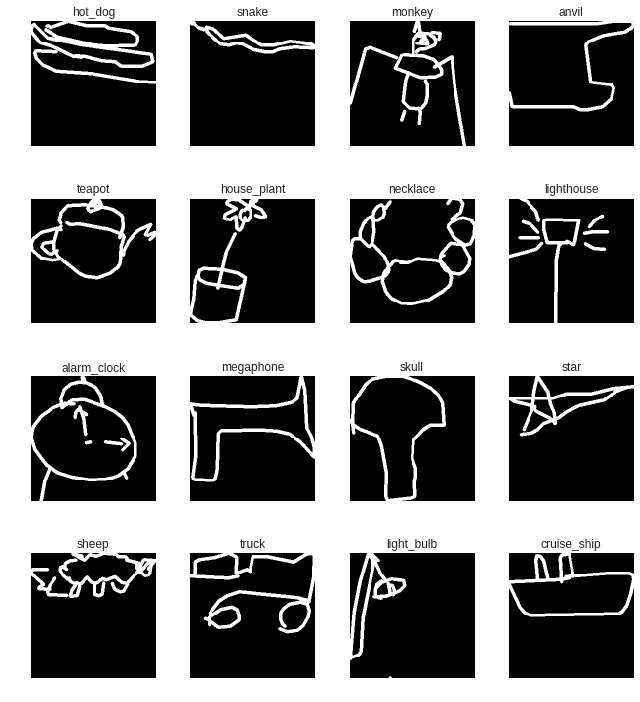

In [48]:
data_bunch.show_batch(rows=4)

In [49]:
%ls data/txt/train

airplane/          cruise_ship/      line/            shoe/
alarm_clock/       cup/              lion/            shorts/
ambulance/         diamond/          lipstick/        shovel/
angel/             dishwasher/       lobster/         sink/
animal_migration/  diving_board/     lollipop/        skateboard/
ant/               dog/              mailbox/         skull/
anvil/             dolphin/          map/             skyscraper/
apple/             donut/            marker/          sleeping_bag/
arm/               door/             matches/         smiley_face/
asparagus/         dragon/           megaphone/       snail/
axe/               dresser/          mermaid/         snake/
backpack/          drill/            microphone/      snorkel/
banana/            drums/            microwave/       snowflake/
bandage/           duck/             monkey/          snowman/
barn/              dumbbell/         moon/            soccer_ball/
baseball/          ear/              mosquito/  

There should be 340 folders for each of the labels.  Each label has 1,000 samples, for a total of 340,000 samples.

In [0]:
name = f'res34-{sz}'

In [51]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 76844800.42it/s]


[Pythorch Model](https://pytorch.org/docs/stable/torchvision/models.html) using this [paper ](https://arxiv.org/abs/1512.03385)from Microsoft Research.

In [52]:
learn.fit_one_cycle(2)

In [0]:
learn.save(f'{name}-stage-1')

The file `res34-128-stage-1.pth` should be now in `models` folder

In [0]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(6, max_lr=6e-4)


In [0]:
learn.save(f'{name}-stage-2')

You should see `res34-128-stage-2.pth` in the `models` folder

# Predict

In [0]:
learn.load(f'{name}-stage-2');

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
PATH1 = Path('subs')
PATH1.mkdir(exist_ok=True)

In [0]:
create_submission(preds, data_bunch.test_dl, name, classes)


In [61]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9307630548749285,grapes blackberry blueberry
1,9702020527625626,watermelon pizza hourglass
2,9893924504621355,computer laptop television
3,9813687402308814,spider fan crab
4,9174447586176505,car police_car school_bus


You should see `subs/res34-128.csv.gz` in the files

In [62]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "Explorers"




100% 1.52M/1.52M [00:09<00:00, 172kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge

In [0]:

!ls sample_data/txt/test | wc -l

112199
